# **ORATS SPX Panel Data Validation**

In [ ]:
%load_ext autoreload
%autoreload 2

import gc

from datetime import date

import exchange_calendars as xcals
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import yfinance as yf

from volatility_trading.config.constants import CALENDAR_DAYS_PER_YEAR
from volatility_trading.data.orats_io import (
    load_orats_panel_lazy, orats_wide_to_long
)
from volatility_trading.data.orats_qc import (
    flag_strike_monotonicity_long,
    summarize_monotonicity_by_region,
)

In [61]:
data = pl.read_parquet("../data/intermediate/orats/by_ticker/underlying=SPY/year=2025/part-0000.parquet")
data

ticker,cOpra,pOpra,stkPx,expirDate,yte,strike,cVolu,cOi,pVolu,pOi,cBidPx,cValue,cAskPx,pBidPx,pValue,pAskPx,cBidIv,cMidIv,cAskIv,smoothSmvVol,pBidIv,pMidIv,pAskIv,iRate,divRate,residualRateData,delta,gamma,theta,vega,rho,phi,driftlessTheta,extVol,extCTheo,extPTheo,spot_px,trade_date
str,str,str,f64,str,f64,f64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""SPY""","""SPY250102C00400000""","""SPY250102P00400000""",584.18,"""1/2/2025""",0.0,400.0,15,8,1,203,182.45,184.18,185.78,0.0,0.0,0.01,0.0,0.0,0.0,0.256595,0.0,0.0,0.0,0.0445,0.0,-0.024919,1.0,-0.0,-0.076074,0.00001,0.000548,-0.0008,-4.0000e-8,0.317152,184.183807,0.0,0.0,"""1/2/2025"""
"""SPY""","""SPY250102C00410000""","""SPY250102P00410000""",584.18,"""1/2/2025""",0.0,410.0,0,2,0,8,172.45,174.18,175.79,0.0,0.0,0.01,0.0,0.0,0.0,0.256595,0.0,0.0,0.0,0.0445,0.0,-0.024919,1.0,-0.0,-0.077976,0.00001,0.000562,-0.0008,-4.0000e-8,0.317152,174.183899,0.0,0.0,"""1/2/2025"""
"""SPY""","""SPY250102C00420000""","""SPY250102P00420000""",584.18,"""1/2/2025""",0.0,420.0,0,107,0,70,162.45,164.18,165.79,0.0,0.0,0.01,0.0,0.0,0.0,0.256595,0.0,0.0,0.0,0.0445,0.0,-0.024919,1.0,-0.0,-0.079878,0.00001,0.000575,-0.0008,-4.0000e-8,0.317152,164.18399,0.0,0.0,"""1/2/2025"""
"""SPY""","""SPY250102C00430000""","""SPY250102P00430000""",584.18,"""1/2/2025""",0.0,430.0,3,85,0,7,152.45,154.18,155.78,0.0,0.0,0.01,0.0,0.0,0.0,0.256595,0.0,0.0,0.0,0.0445,0.0,-0.024919,1.0,-0.0,-0.08178,0.00001,0.000589,-0.0008,-4.0000e-8,0.317152,154.184082,0.0,0.0,"""1/2/2025"""
"""SPY""","""SPY250102C00440000""","""SPY250102P00440000""",584.18,"""1/2/2025""",0.0,440.0,0,2,0,117,142.45,144.18,145.79,0.0,0.0,0.01,0.0,0.0,0.0,0.256595,0.0,0.0,0.0,0.0445,0.0,-0.024919,1.0,-0.0,-0.083682,0.00001,0.000603,-0.0008,-4.0000e-8,0.269832,144.184189,0.0,0.0,"""1/2/2025"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SPY""","""SPY280121C01300000""","""SPY280121P01300000""",685.61,"""1/21/2028""",2.12877,1300.0,0,221,0,0,0.3,0.31,0.33,612.0,614.39,616.75,0.153228,0.15401,0.154786,0.148779,0.0,0.19577,0.39154,0.0355,0.0,-0.005923,0.005077,0.000098,-0.001662,0.150613,0.069221,-0.074079,-0.001362,0.158795,0.418109,614.390015,0.0,"""12/5/2025"""
"""SPY""","""SPY280121C01310000""","""SPY280121P01310000""",685.61,"""1/21/2028""",2.12877,1310.0,0,158,0,0,0.27,0.28,0.34,622.0,624.39,626.75,0.153331,0.15521,0.157083,0.148779,0.0,0.19757,0.395149,0.0355,0.0,-0.005923,0.004544,0.000089,-0.001503,0.152807,0.062,-0.066304,-0.001234,0.158795,0.373958,624.390015,0.0,"""12/5/2025"""
"""SPY""","""SPY280121C01320000""","""SPY280121P01320000""",685.61,"""1/21/2028""",2.12877,1320.0,0,179,0,0,0.26,0.28,0.32,632.0,634.39,636.75,0.154359,0.15607,0.157782,0.148779,0.0,0.19936,0.39873,0.0355,0.0,-0.005923,0.004077,0.00008,-0.001362,0.114853,0.055672,-0.059498,-0.001121,0.158795,0.339186,634.390015,0.0,"""12/5/2025"""


# Read SPX Options data 

We analyse the whole chain from `2007-01-01` to `2025-12-05` and we remove contracts outside the 1%-99% Delta range for calls and puts.


In [2]:
start = date(2007, 1, 1)
end = date(2025, 12, 31)

cols = [
    "ticker",
    "trade_date",
    "expiry_date",
    "dte",
    "yte",
    "strike",
    "underlying_price",
    "spot_price",
    "smoothed_iv",
    "call_mid_iv","put_mid_iv",
    "call_volume", "put_volume",
    "call_open_interest", "put_open_interest",
    "call_rel_spread", "put_rel_spread",
    "call_bid_price", "put_bid_price",
    "call_mid_price", "put_mid_price",
    "call_ask_price", "put_ask_price",
    "call_delta", "put_delta",
    "call_gamma", "put_gamma",
    "call_theta", "put_theta",
    "call_vega", "put_vega",
    "call_rho", "put_rho",
    "risk_free_rate", "dividend_yield",
]

lf = load_orats_panel_lazy("SPX", columns=cols)
lf = lf.filter(
    pl.col("trade_date").is_between(start, end),
    pl.col("call_delta").abs().is_between(0.01, 0.99),
    pl.col("put_delta").abs().is_between(0.01, 0.99),
)

df = lf.collect()
df_long = orats_wide_to_long(df).filter().collect()
df

ticker,trade_date,expiry_date,dte,yte,strike,underlying_price,spot_price,smoothed_iv,call_mid_iv,put_mid_iv,call_volume,put_volume,call_open_interest,put_open_interest,call_rel_spread,put_rel_spread,call_bid_price,put_bid_price,call_mid_price,put_mid_price,call_ask_price,put_ask_price,call_delta,put_delta,call_gamma,put_gamma,call_theta,put_theta,call_vega,put_vega,call_rho,put_rho,risk_free_rate,dividend_yield
str,date,date,i64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""SPX""",2007-01-03,2007-01-20,17,0.04658,1330.0,1414.8,1397.68,0.130463,0.0897,0.16507,0,44,96,20055,0.022573,0.714286,87.6,0.45,88.6,0.7,89.6,0.95,0.989844,-0.010156,0.000679,0.000679,-0.2505,-0.426464,0.093225,0.093225,0.611189,-0.006929,0.0484,0.0
"""SPX""",2007-01-03,2007-01-20,17,0.04658,1335.0,1414.8,1397.68,0.13003,0.08676,0.16047,0,871,124,29467,0.023895,0.580645,82.7,0.55,83.7,0.775,84.7,1.0,0.985808,-0.014192,0.00091,0.00091,-0.260895,-0.437521,0.117067,0.117067,0.610823,-0.00962,0.0484,0.0
"""SPX""",2007-01-03,2007-01-20,17,0.04658,1340.0,1414.8,1397.68,0.129422,0.08385,0.15689,0,2607,446,62449,0.025381,0.555556,77.8,0.65,78.8,0.9,79.8,1.15,0.980553,-0.019447,0.001197,0.001197,-0.273249,-0.450537,0.144801,0.144801,0.609643,-0.013123,0.0484,0.0
"""SPX""",2007-01-03,2007-01-20,17,0.04658,1345.0,1414.8,1397.68,0.128842,0.08063,0.15184,0,1591,60,23460,0.027064,0.5,72.9,0.75,73.9,1.0,74.9,1.25,0.973872,-0.026128,0.001544,0.001544,-0.287797,-0.465746,0.177971,0.177971,0.60751,-0.01758,0.0484,0.0
"""SPX""",2007-01-03,2007-01-20,17,0.04658,1350.0,1414.8,1397.68,0.128218,0.07858,0.1467,5776,2245,10320,101031,0.028944,0.181818,68.1,1.0,69.1,1.1,70.1,1.2,0.96533,-0.03467,0.001964,0.001964,-0.304815,-0.483426,0.2158289,0.2158289,0.604134,-0.02328,0.0484,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SPX""",2025-12-05,2026-02-27,84,0.23014,7640.0,6924.58,6870.04,0.118568,0.11785,0.05795,0,0,0,0,0.043796,0.009796,6.7,711.1,6.85,714.6,7.0,718.1,0.04436,-0.95564,0.000238,0.000238,-0.220277,-0.990233,3.032522,3.032522,0.681893,-16.751318,0.0371,0.0
"""SPX""",2025-12-05,2026-02-27,84,0.23014,7650.0,6924.58,6870.04,0.118699,0.11796,0.05623,0,0,268,0,0.030769,0.008564,6.4,720.9,6.5,724.0,6.6,727.1,0.042442,-0.957558,0.000229,0.000229,-0.212733,-0.983698,3.035002,3.035002,0.652737,-16.803292,0.0371,0.0
"""SPX""",2025-12-05,2026-02-27,84,0.23014,7700.0,6924.58,6870.04,0.119343,0.11897,0.0,1,0,170,2,0.039216,0.009982,5.0,767.5,5.1,771.35,5.2,775.2,0.033716,-0.966284,0.000189,0.000189,-0.177317,-0.953321,2.547654,2.547654,0.519758,-17.050363,0.0371,0.0


In [ ]:
df.describe()

statistic,ticker,trade_date,expiry_date,dte,yte,strike,underlying_price,spot_price,smoothed_iv,call_mid_iv,put_mid_iv,call_volume,put_volume,call_open_interest,put_open_interest,call_rel_spread,put_rel_spread,call_bid_price,put_bid_price,call_mid_price,put_mid_price,call_ask_price,put_ask_price,call_delta,put_delta,call_gamma,put_gamma,call_theta,put_theta,call_vega,put_vega,call_rho,put_rho,risk_free_rate,dividend_yield
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""8278626""","""8278626""","""8278626""",8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278345e6,8.278411e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6
"""null_count""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,281.0,215.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,"""2020-12-02 21:52:03.442658""","""2021-01-11 07:52:16.650067""",39.41682,0.107992,3731.658019,3884.851301,3874.187944,0.208599,0.202203,0.201839,105.450198,163.383251,1104.062479,1614.16795,0.040053,0.045475,235.328798,78.46931,237.054856,79.380056,238.780915,80.290802,0.633223,-0.366777,0.001438,0.001438,-0.883768,-1.178535,2.728749,2.728749,2.023852,-1.872143,0.023475,0.0
"""std""",null,null,null,23.004156,0.063025,1461.87565,1473.94919,1463.465216,0.098939,0.100995,0.106756,888.880581,1174.431088,6533.358406,8313.705274,0.103265,0.084074,267.026293,115.420699,268.373572,116.625534,269.730432,117.839948,0.324899,0.324899,0.001503,0.001503,0.715682,0.863897,2.16205,2.16205,1.716915,2.148312,0.021346,0.0
"""min""","""SPX""","""2007-01-03""","""2007-01-12""",7.0,0.01918,350.0,672.995,667.5,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,-0.99,0.000017,0.000017,-12.96251,-13.534207,0.025404,0.025404,0.001448,-18.942357,0.0,0.0
"""25%""",null,"""2018-09-04""","""2018-10-17""",21.0,0.05753,2550.0,2712.335797,2717.7,0.13524,0.13009,0.13219,0.0,0.0,0.0,5.0,0.008534,0.012414,34.9,8.5,35.25,8.75,35.7,8.9,0.361527,-0.638473,0.000448,0.000448,-1.240543,-1.740994,1.022589,1.022589,0.714846,-2.522048,0.001,0.0
"""50%""",null,"""2021-10-27""","""2021-12-03""",35.0,0.09589,3765.0,3956.79,3942.2,0.189536,0.18037,0.188701,0.0,3.0,16.0,64.0,0.015548,0.023715,148.2,32.0,149.55,32.35,150.9,32.7,0.753189,-0.246811,0.001,0.001,-0.735357,-1.02066,2.203427,2.203427,1.578052,-1.118084,0.0195,0.0
"""75%""",null,"""2024-01-24""","""2024-02-29""",57.0,0.15616,4755.0,4852.25,4828.58,0.258559,0.24878,0.2569,10.0,25.0,171.0,364.0,0.032777,0.046512,336.9,99.3,339.75,100.35,342.6,101.4,0.919242,-0.080758,0.001883,0.001883,-0.341775,-0.456682,3.850525,3.850525,2.875435,-0.398478,0.0438,0.0
"""max""","""SPX""","""2025-12-05""","""2026-02-27""",90.0,0.24658,8000.0,6956.33,6899.64,1.52649,1.936547,1.550114,140444.0,148838.0,380865.0,417654.0,2.0,2.0,2533.7,1394.5,2541.9,1403.4,2550.1,1412.3,0.99,-0.01,0.041888,0.041888,-0.003131,-0.003665,13.481006,13.481006,10.24198,0.010222,0.0602,0.0


- Ensure timestamps are not duplicated or missing in regular intervals.

In [42]:
key_cols = ["trade_date", "expiry_date", "strike"]

is_sorted = df.select(key_cols).equals(
    df.select(key_cols).sort(key_cols)
)

print("Sorted by trade_date, expiry_date, strike? ->", is_sorted)

Sorted by trade_date, expiry_date, strike? -> True


In [11]:
# Get unique trade dates from ORATS
trade_dates = (
    df_long
    .select("trade_date")
    .unique()
    .sort("trade_date")
    .to_series()
    .to_list()   
)

min_date = min(trade_dates)
max_date = max(trade_dates)

print("Min trade_date:", min_date)
print("Max trade_date:", max_date)

# Official US equity trading days (XNYS)
cal = xcals.get_calendar("XNYS")
schedule = cal.schedule.loc[min_date:max_date]

trading_days = schedule.index.date.tolist()

# Compare with ORATS dates
existing = set(trade_dates)
missing = sorted(d.strftime("%Y-%m-%d") for d in trading_days if d not in existing)

print(f"Missing trading days: {len(missing)}")
print("First few:", missing[:10])

Min trade_date: 2007-01-03
Max trade_date: 2025-12-05
Missing trading days: 1
First few: ['2018-12-07']


# **Days-to-expiry check**

Over the years we should see min and max dte for each day becomeign closer toà 7 and 60 DTE while a global  min and max DTE of 7 and 60 

In [43]:
trade_expiry_violations = df.filter(
    (pl.col("trade_date") >= pl.col("expiry_date"))
)
print("Number of violation:", trade_expiry_violations.height)

Number of violation: 0


In [21]:
dte_yte_check = (
    df
    .group_by(["trade_date"])
    .agg(
        pl.col("dte").min().alias("dte_min"),
        pl.col("dte").max().alias("dte_max"),
        (pl.col("dte") - pl.col("yte") * CALENDAR_DAYS_PER_YEAR)
        .abs()
        .mean()
        .alias("mean_abs_diff"),
    )
    .sort("trade_date")
)

dte_min_global = df.select(pl.col("dte").min()).item()
dte_max_global = df.select(pl.col("dte").max()).item()

print(f"Global DTE range: [{dte_min_global}, {dte_max_global}]")
dte_yte_check

Global DTE range: [7, 90]


trade_date,dte_min,dte_max,mean_abs_diff
date,i64,i64,f64
2007-01-03,17,86,0.000841
2007-01-04,16,85,0.000777
2007-01-05,15,84,0.000732
2007-01-08,12,81,0.000634
2007-01-09,11,80,0.000605
…,…,…,…
2024-11-20,7,72,0.000807
2024-11-21,8,71,0.000827
2024-11-22,7,70,0.000828


# **Quote sanity checks**

Here we consider: 

1. Hard data errors → OK to drop (or treat as invalid)

These are basically never acceptable:
	•	is_bid_negative
→ Bid < 0 is just impossible. That’s a data error.
	•	is_ask_negative
→ Same: ask < 0 is a data error.
bid > ask
➡️ Policy: rows with any of these flags = candidates for dropping from the processed panel.


2. Suspicious / rare edge cases → investigate, then decide
Locked markets (bid == ask) can happen (super tight markets), especially on very liquid options near the close.
If:
	•	They are rare, and
	•	In sensible regions (ATM, decent volume, narrow absolute spread),
…I’d treat them as valid but noteworthy, not errors.

In [44]:
df_long = orats_wide_to_long(df).filter().collect()

In [23]:
cols_quote_checks = [
    "trade_date", "dte", "volume", "open_interest", 
    "rel_spread","bid_price", "mid_price", "ask_price", "delta"
]

quote_flags = (
    df_long
    .with_columns(
        # Basic checks
        is_bid_negative = (pl.col("bid_price") < 0),
        is_ask_negative = (pl.col("ask_price") < 0),

        # Crossed & locked markets
        is_crossed = pl.col("bid_price") > pl.col("ask_price"),
        is_locked  = (pl.col("bid_price") == pl.col("ask_price")) 
                     & (pl.col("bid_price") > 0),

        # One-sided quote (no bid, positive ask)
        is_one_sided = (pl.col("bid_price") == 0) & (pl.col("ask_price") > 0),
        is_mild_wide = pl.col("rel_spread") > 1.0,   # > 100% of mid
        is_very_wide = pl.col("rel_spread") > 2.0,   # > 200% of mid
    )
)

quote_summary = quote_flags.select(
    pl.len().alias("n_rows"),
    pl.col("is_bid_negative").sum().alias("n_bid_negative"),
    pl.col("is_ask_negative").sum().alias("n_ask_negative"),
    pl.col("is_crossed").sum().alias("n_crossed"),
    pl.col("is_locked").sum().alias("n_locked"),
    pl.col("is_one_sided").sum().alias("n_one_sided"),
    pl.col("is_mild_wide").sum().alias("n_mild_wide"),
    pl.col("is_very_wide").sum().alias("n_very_wide"),
)

quote_summary

n_rows,n_bid_negative,n_ask_negative,n_crossed,n_locked,n_one_sided,n_mild_wide,n_very_wide
u32,u32,u32,u32,u32,u32,u32,u32
5453462,0,0,0,409,2587,7267,0


No big data errors are spotted for crossed and negative ask/bid whihc is very good while a very samll proportion of microstructure errors that need further investgtaions.

In [24]:
dte_buckets = [0, 10, 30, 60]
delta_buckets = [0, 0.05, 0.1, 0.25, 0.35, 0.5, 0.75, 0.9, 1.0]

one_sided = (
    quote_flags
    .filter(pl.col("is_one_sided"))
    .select(
        pl.col("dte").cut(dte_buckets).alias("dte_bucket"),
        pl.col("delta").abs().cut(delta_buckets).alias("abs_delta_bucket"),
    )
    .group_by("dte_bucket", "abs_delta_bucket")
    .agg(pl.len().alias("n"))
    .sort("n", descending=True)
)

one_sided.head(10)

dte_bucket,abs_delta_bucket,n
cat,cat,u32
"""(60, inf]""","""(0, 0.05]""",906
"""(30, 60]""","""(0, 0.05]""",814
"""(10, 30]""","""(0, 0.05]""",558
"""(0, 10]""","""(0, 0.05]""",171
"""(60, inf]""","""(0.1, 0.25]""",32
"""(60, inf]""","""(0.05, 0.1]""",28
"""(10, 30]""","""(0.05, 0.1]""",20
"""(30, 60]""","""(0.05, 0.1]""",11
"""(10, 30]""","""(0.1, 0.25]""",9


In [25]:
mild_wide = (
    quote_flags
    .filter(pl.col("is_mild_wide"))
    .select(
        pl.col("dte").cut(dte_buckets).alias("dte_bucket"),
        pl.col("delta").abs().cut(delta_buckets).alias("abs_delta_bucket"),
    )
    .group_by("dte_bucket", "abs_delta_bucket")
    .agg(pl.len().alias("n"))
    .sort("n", descending=True)
)

mild_wide.head(10)

dte_bucket,abs_delta_bucket,n
cat,cat,u32
"""(60, inf]""","""(0, 0.05]""",2405
"""(30, 60]""","""(0, 0.05]""",2357
"""(10, 30]""","""(0, 0.05]""",1415
"""(0, 10]""","""(0, 0.05]""",384
"""(30, 60]""","""(0.05, 0.1]""",139
"""(30, 60]""","""(0.1, 0.25]""",120
"""(10, 30]""","""(0.1, 0.25]""",75
"""(60, inf]""","""(0.1, 0.25]""",71
"""(10, 30]""","""(0.05, 0.1]""",59


In [26]:
quote_flags.filter(
    pl.col("is_locked")
).select(cols_quote_checks)

trade_date,dte,volume,open_interest,rel_spread,bid_price,mid_price,ask_price,delta
date,i64,i64,i64,f64,f64,f64,f64,f64
2007-04-11,10,8457,55316,0.0,1.05,1.05,1.05,0.525356
2007-04-11,10,11950,73656,0.0,0.55,0.55,0.55,0.347365
2007-04-11,38,1543,26495,0.0,2.55,2.55,2.55,0.554704
2007-04-11,38,796,18280,0.0,1.4,1.4,1.4,0.402062
2007-10-31,17,10089,31487,0.0,0.47,0.47,0.47,0.197406
…,…,…,…,…,…,…,…,…
2023-11-17,11,78,3882,0.0,0.47,0.47,0.47,-0.101519
2023-11-27,7,29,53,0.0,0.07,0.07,0.07,-0.014558
2023-12-04,10,17,54,0.0,0.16,0.16,0.16,-0.028067


The very samll number of the locked quotes, large relativr spread and one sided quotes happen for deep OTM Puts and calls so we are safe to jsut ignore them as they are not part of our 0.1-0.9 trading region.

# **Volume & Open Interest Checks**

	•	Negative volume / open_interest → hard data errors (should be 0 in a clean dataset).
	•	volume = 0, OI > 0 → normal (listed but not traded that day).
	•	volume > 0, OI = 0 → can happen for very new listings / data timing issues; should be rare and require further investigations.

In [27]:
vol_oi_flags = (
    df_long
    .with_columns(
        # basic sign checks
        is_volume_negative = pl.col("volume") < 0,
        is_oi_negative = pl.col("open_interest") < 0,

        # zeros
        is_volume_zero = pl.col("volume") == 0,
        is_oi_zero = pl.col("open_interest") == 0,

        # mismatched cases
        is_zero_vol_pos_oi = (
            (pl.col("volume") == 0)
            & (pl.col("open_interest") > 0)
        ),
        is_pos_vol_zero_oi = (
            (pl.col("volume") > 0)
            & (pl.col("open_interest") == 0)
        ),
    )
)

vol_oi_summary = (
    vol_oi_flags
    .select(
        pl.len().alias("n_rows"),
        pl.col("is_volume_negative").sum().alias("n_volume_negative"),
        pl.col("is_oi_negative").sum().alias("n_oi_negative"),
        pl.col("is_volume_zero").sum().alias("n_volume_zero"),
        pl.col("is_oi_zero").sum().alias("n_oi_zero"),
        pl.col("is_zero_vol_pos_oi").sum().alias("n_zero_vol_pos_oi"),
        pl.col("is_pos_vol_zero_oi").sum().alias("n_pos_vol_zero_oi"),
    )
    .with_columns(
        (pl.col("n_volume_negative") / pl.col("n_rows"))
        .alias("pct_volume_negative"),
        (pl.col("n_oi_negative") / pl.col("n_rows"))
        .alias("pct_oi_negative"),
        (pl.col("n_zero_vol_pos_oi") / pl.col("n_rows"))
        .alias("pct_zero_vol_pos_oi"),
        (pl.col("n_pos_vol_zero_oi") / pl.col("n_rows"))
        .alias("pct_pos_vol_zero_oi"),
    )
)

vol_oi_summary

n_rows,n_volume_negative,n_oi_negative,n_volume_zero,n_oi_zero,n_zero_vol_pos_oi,n_pos_vol_zero_oi,pct_volume_negative,pct_oi_negative,pct_zero_vol_pos_oi,pct_pos_vol_zero_oi
u32,u32,u32,u32,u32,u32,u32,f64,f64,f64,f64
5453462,0,0,1147989,740610,622759,215380,0.0,0.0,0.114195,0.039494


No sign violations, volume is more oftne zero than OI whihc is expected while zero vol with positive OI happen much more frequenctly tha the otehr way. Hwoever, the pct of Vol > 0 & OI = 0 is still roughly 2.7% so we still investgiate where they occur.

In [28]:
df_long.select("volume").describe()

statistic,volume
str,f64
"""count""",5.453462e6
"""null_count""",0.0
"""mean""",1049.623703
"""std""",4713.895703
"""min""",0.0
"""25%""",1.0
"""50%""",36.0
"""75%""",351.0
"""max""",532902.0


In [15]:
pos_vol_zero_oi = (
    vol_oi_flags
    .filter(pl.col("is_pos_vol_zero_oi"))
    .select(
        pl.col("dte").cut(dte_buckets).alias("dte_bucket"),
        pl.col("delta").abs().cut(delta_buckets).alias("abs_delta_bucket"),
    )
    .group_by("dte_bucket", "abs_delta_bucket")
    .agg(pl.len().alias("n"))
    .sort("n", descending=True)
)

pos_vol_zero_oi.head(10)

dte_bucket,abs_delta_bucket,n
cat,cat,u32
"""(10, 30]""","""(0.5, 0.75]""",47238
"""(30, 60]""","""(0.5, 0.75]""",40632
"""(30, 60]""","""(0.1, 0.25]""",34556
"""(10, 30]""","""(0.1, 0.25]""",33205
"""(10, 30]""","""(0.35, 0.5]""",29755
"""(30, 60]""","""(0.35, 0.5]""",28773
"""(10, 30]""","""(0.75, 0.9]""",19996
"""(30, 60]""","""(0.25, 0.35]""",19179
"""(10, 30]""","""(0.25, 0.35]""",18928


Those situations happen in our tardebale region so it requires a deeper look, here we look at volume buckets to check if those scenarios happen in high or low volume environment.

In [16]:
volume_bins = [0, 5, 10, 50, 100, 1000, 5000, 1e9]
n_total = vol_oi_summary.select("n_rows").item()

vol_by_bucket = (
    vol_oi_flags
    .filter(pl.col("is_pos_vol_zero_oi"))
    .with_columns(
        volume_bucket = pl.col("volume").cut(volume_bins),
    )
    .group_by("volume_bucket")
    .agg(
        pl.len().alias("n"),
        pl.col("volume").mean().alias("avg_volume"),
        (pl.len() / pl.lit(n_total)).alias("pct_of_all_rows"),
    )
    .with_columns(
        (pl.col("n") / pl.col("n").sum()).alias("pct_within_flagged")
    ).sort("n", descending=True)
)

vol_by_bucket

volume_bucket,n,avg_volume,pct_of_all_rows,pct_within_flagged
cat,u32,f64,f64,f64
"""(0, 5]""",238040,2.266287,0.014377,0.530292
"""(10, 50]""",99593,23.032211,0.006015,0.221868
"""(5, 10]""",66376,8.057882,0.004009,0.147869
"""(100, 1000]""",21807,287.6414,0.001317,0.04858
"""(50, 100]""",19238,71.877742,0.001162,0.042857
"""(1000, 5000]""",3299,1947.50773,0.000199,0.007349
"""(5000, 1000000000]""",532,11151.293233,0.000032,0.001185


More than 50% of the 0 Open Interets happen in trading volumes less than 5 and 90% occur for volumes less than 50 so we are safely ignore them.

# **Spot price sanity checks**

- One `spot_price` per trade_date
- Compare to external index close (if you want)
- Check for jumps / obvious glitches

## Multiple Spot per day Check

In [29]:
spot_check = (
    df
    .group_by("trade_date")
    .agg(
        pl.col("spot_price").n_unique().alias("n_spot_values"),
        pl.col("spot_price").min().alias("spot_min"),
        pl.col("spot_price").max().alias("spot_max"),
    )
    .sort("trade_date")
)

spot_issues = spot_check.filter(pl.col("n_spot_values") > 1)
print("Number of multiple spots per day violations:", spot_issues.height)
spot_check

Number of multiple spots per day violations: 0


trade_date,n_spot_values,spot_min,spot_max
date,u32,f64,f64
2007-01-03,1,141.37,141.37
2007-01-04,1,141.67,141.67
2007-01-05,1,140.54,140.54
2007-01-08,1,141.19,141.19
2007-01-09,1,141.07,141.07
…,…,…,…
2024-11-20,1,589.63,589.63
2024-11-21,1,594.23,594.23
2024-11-22,1,594.97,594.97


## ORATS SPX vs Yahoo Finance SPX

In [3]:
spx_yf = yf.download("^SPX", start=start, end=end, auto_adjust=True)["Close"]
spx_yf = spx_yf.squeeze()
spx_yf.name = "spx_yf"

spx_orats = (
    df
    .group_by("trade_date")
    .agg(pl.col("spot_price").first())
    .sort("trade_date")
    .to_pandas()
    .set_index("trade_date")
    .rename(columns={"spot_price": "spx_orats"})
)

spx = pd.concat([spx_yf, spx_orats], axis=1).dropna()
spx

[*********************100%***********************]  1 of 1 completed


,spx_yf,spx_orats
2007-01-03,1416.599976,1397.68
2007-01-04,1418.339966,1400.48
2007-01-05,1409.709961,1389.35
2007-01-08,1412.839966,1396.15
2007-01-09,1412.109985,1394.39
...,...,...
2025-12-01,6812.629883,6823.63
2025-12-02,6829.370117,6834.96
2025-12-03,6849.720215,6859.93
2025-12-04,6857.120117,6838.80


In [4]:
diff = spx["spx_orats"] - spx["spx_yf"]
rel_diff = diff / spx["spx_yf"]

summary = pd.DataFrame({
    "abs_diff": diff.abs(),
    "rel_diff": rel_diff,
}).describe(percentiles=[0.5, 0.9, 0.99])

corr = spx.corr().loc["spx_yf", "spx_orats"]

print("Correlation:", corr)
display(summary)

Correlation: 0.9999663602742882


,abs_diff,rel_diff
count,4762.000000,4762.000000
mean,10.676674,-0.004746
std,10.439809,0.006124
min,0.000000,-0.033508
50%,8.395039,-0.001758
90%,23.828906,0.001031
99%,41.373717,0.004536
max,103.379805,0.024081


Here the small discrepency is natutal because ORATS collect data 14 minutes before the exchange closes.

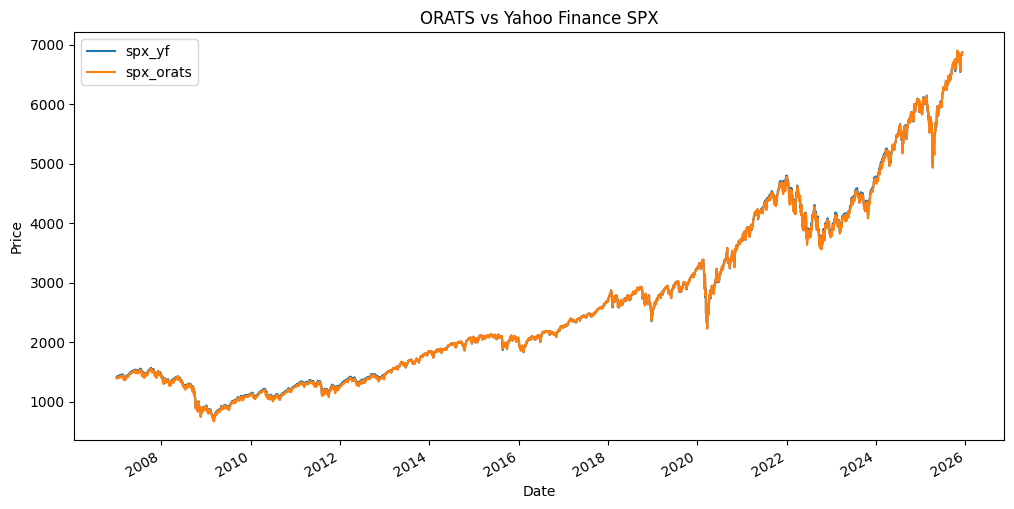

In [5]:
spx.plot(figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("ORATS vs Yahoo Finance SPX")
plt.show()

# **Parity-Implied Forward Index Price Check**

For SPX index options, the cash index level is observable, but the
per-maturity forward price used in option pricing is not directly quoted.
ORATS therefore infers a forward price for each expiry using put–call parity.

As a sanity check, we:

- Compare the **number of distinct forward prices per trade date** to the
  **number of expiries** (they should be close).
- Check that for a given `(trade_date, expiry_date)` the implied forward is
  essentially **unique across strikes**.

Small deviations across strikes are expected due to noise and microstructure.
Large discrepancies or a very messy forward surface would suggest potential
data or modelling issues.

## Match between nb of expiries and future implied Prices

In [6]:
underlying_checks_expiry_match = (
    df
    .group_by("trade_date")
    .agg(
        pl.col("underlying_price").n_unique().alias("n_spot_values"),
        pl.col("expiry_date").n_unique().alias("n_expiries"),
        pl.col("underlying_price").min().alias("spot_min"),
        pl.col("underlying_price").max().alias("spot_max"),
    )
    .sort("trade_date")
)

underlying_checks_expiry_match.filter(pl.col("n_spot_values") != pl.col("n_expiries"))

trade_date,n_spot_values,n_expiries,spot_min,spot_max
date,u32,u32,f64,f64
2007-02-22,3,4,1451.84,1454.37
2007-05-21,3,4,1519.25,1522.63
2007-11-07,3,4,1476.42,1477.71
2007-11-29,3,4,1466.95,1467.98
2008-01-15,2,3,1380.84,1382.1
…,…,…,…,…
2025-11-03,27,29,6858.3,6915.5
2025-11-04,28,29,6791.02,6847.52
2025-11-07,28,29,6722.27,6775.45


## Check for the nb of future implied prices across expiries

In [29]:
underlying_by_expiry = (
    df
    .group_by("trade_date", "expiry_date")
    .agg(
        pl.col("underlying_price").n_unique().alias("n_spot_values"),
        pl.col("underlying_price").min().alias("u_min"),
        pl.col("underlying_price").max().alias("u_max"),
    )
    .with_columns(
        (pl.col("u_max") - pl.col("u_min")).alias("abs_range"),
        ((pl.col("u_max") - pl.col("u_min")) / pl.col("u_min")).alias("rel_range"),
    )
    .sort("abs_range", descending=True)
)

n_total = underlying_by_expiry.height
expiry_viol = underlying_by_expiry.filter(pl.col("n_spot_values") > 1)
max_expiry_viol = expiry_viol.select("n_spot_values").max().item()

print(f"Percentage of violations: {expiry_viol.height/n_total:.1%}")
print(f"Maximum number of prices across strikes:", max_expiry_viol)
expiry_viol

: 

In [8]:
expiry_viol.select(
    pl.col("trade_date").min().alias("Min date"),
    pl.col("trade_date").max().alias("Max date"),
)

Min date,Max date
date,date
null,null


In [9]:
example = underlying_by_expiry.sort("rel_range", descending=True)[111]
ex_date = example[0, "trade_date"]
ex_exp  = example[0, "expiry_date"]

df_example = (
    df
    .filter(
        (pl.col("trade_date") == ex_date) &
        (pl.col("expiry_date") == ex_exp)
    )
    .select(
        "trade_date", "expiry_date",
        "strike",
        "dte",
        "call_delta",
        "underlying_price",
        "call_bid_price", "call_ask_price",
        "put_bid_price",  "put_ask_price",
        "call_volume",    "put_volume",
    )
    .sort("strike")
)

df_example.head(68)

trade_date,expiry_date,strike,dte,call_delta,underlying_price,call_bid_price,call_ask_price,put_bid_price,put_ask_price,call_volume,put_volume
date,date,f64,i64,f64,f64,f64,f64,f64,f64,i64,i64
2015-05-12,2015-07-10,1620.0,59,0.989838,2094.502536,467.1,484.7,0.8,1.15,0,1
2015-05-12,2015-07-10,1625.0,59,0.9892,2094.502536,462.1,480.1,0.8,1.0,0,1093
2015-05-12,2015-07-10,1630.0,59,0.98887,2094.502536,457.1,474.8,0.85,1.25,0,0
2015-05-12,2015-07-10,1635.0,59,0.98826,2094.502536,452.2,469.8,0.85,1.3,0,0
2015-05-12,2015-07-10,1640.0,59,0.987561,2094.502536,447.2,465.2,0.85,1.35,0,0
…,…,…,…,…,…,…,…,…,…,…,…
2015-05-12,2015-07-10,1935.0,59,0.866246,2094.502536,169.6,171.6,10.8,11.7,5,10
2015-05-12,2015-07-10,1940.0,59,0.860481,2094.502536,165.1,167.1,11.3,12.2,0,3
2015-05-12,2015-07-10,1945.0,59,0.854494,2094.502536,160.6,162.6,11.8,12.7,27,4


# **Risk free rate check**

In [11]:
rate_check = (
    df
    .group_by(["trade_date"])
    .agg(
        pl.col("risk_free_rate").n_unique().alias("n_rf"),
        pl.col("risk_free_rate").min().alias("rf_min"),
        pl.col("risk_free_rate").max().alias("rf_max"),
    )
    .sort(["trade_date"])
)

rate_issues = rate_check.filter(pl.col("n_rf") > 1)
nb_rate_issues = rate_issues.height
nb_rate_checks = rate_check.height

print(f"Proportion of non unique rates checks: {nb_rate_issues/nb_rate_checks:.4%}")
rate_issues

Proportion of non unique rates checks: 84.9223%


trade_date,n_rf,rf_min,rf_max
date,u32,f64,f64
2007-01-03,2,0.0484,0.0505
2007-01-04,2,0.048,0.0504
2007-01-05,2,0.0481,0.0505
2007-01-08,2,0.0487,0.0508
2007-01-09,2,0.049,0.0508
…,…,…,…
2025-12-01,2,0.0392,0.0406
2025-12-02,2,0.0381,0.0398
2025-12-03,2,0.0377,0.039


# **Implied Volatility Quality Checks**

In [12]:
iv_stats = df.select(pl.col("smoothed_iv")).describe()
iv_stats

statistic,smoothed_iv
str,f64
"""count""",7.507851e6
"""null_count""",0.0
"""mean""",0.2077
"""std""",0.099923
"""min""",0.01
"""25%""",0.134197
"""50%""",0.188153
"""75%""",0.256956
"""max""",1.52649


In [13]:
df.select(
    (pl.col("smoothed_iv") < 0).sum().alias("n_negative"),
    (pl.col("smoothed_iv") > 3.0).sum().alias("n_above_300pct"),
)

n_negative,n_above_300pct
u32,u32
0,0


## Smile shape for 10, 30 and 60 DTE

**What we’re looking for**

- Smiles are **smooth** functions of strike (no crazy spikes for single strikes).
- Shorter maturities show more curvature / higher IV during stressed periods.
- Shapes are consistent with equity index behaviour:
  - Higher IV for low deltas (OTM puts),
  - Lower IV for high deltas (OTM calls), i.e. a negative skew.
- No obvious arbitrage-like patterns:
  - IV not wildly non-monotone in wings,
  - Different maturities do not cross each other in pathological ways.

In [14]:
picked_dates = [
    date(2010, 12, 2),
    date(2013, 6, 13),
    date(2018, 9, 12),
    date(2025, 3, 3),
]

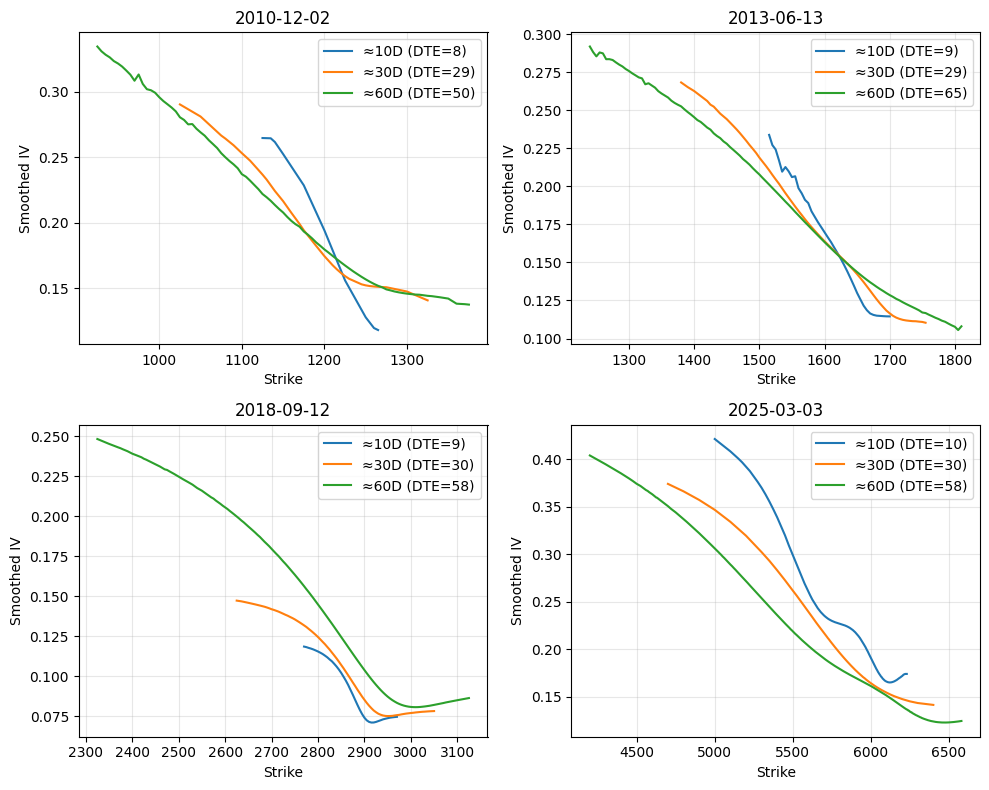

In [15]:
def pick_closest_dte(dtes: list[int], target: int, max_tol: int = 5):
    """
    Return the DTE closest to `target` within `max_tol` days, else None.
    """
    if not dtes:
        return None
    best = min(dtes, key=lambda d: abs(d - target))
    return best if abs(best - target) <= max_tol else None


targets = [
    (10, "≈10D"),
    (30, "≈30D"),
    (60, "≈60D"),
]

nrows, ncols = 2, 2
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(5 * ncols, 4 * nrows),
    sharex=False,
    sharey=False,
)
axes = axes.ravel()

for ax, day in zip(axes, picked_dates):
    sub = df.filter(pl.col("trade_date") == day)
    if sub.height == 0:
        ax.set_axis_off()
        continue

    dtes = (sub.select(pl.col("dte").unique()).sort("dte").to_series().to_list())

    chosen = {}
    for target, label in targets:
        best = pick_closest_dte(dtes, target, max_tol=10)
        if best is not None:
            chosen[label] = best

    if not chosen:
        ax.set_axis_off()
        continue

    for label, dte_val in chosen.items():
        grp = (
            sub
            .filter(pl.col("dte") == dte_val)
            .sort("strike")
        )
        if grp.height == 0:
            continue

        ax.plot(
            grp["strike"].to_numpy(),
            grp["smoothed_iv"].to_numpy(),
            label=f"{label} (DTE={dte_val})",
            linewidth=1.5,
        )
    ax.set_xlabel("Strike")
    ax.set_ylabel("Smoothed IV")
    ax.set_title(day.strftime("%Y-%m-%d"))
    ax.grid(True, alpha=0.3)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc="upper right")

for k in range(len(picked_dates), len(axes)):
    axes[k].set_axis_off()

fig.tight_layout()
plt.show()

The smootthed IV alreadu comes from a smoothed surface so a single linear interpolation between the reporetd strikes is enough and does not require any smoothing. Thus if we would request a particular striek we would jsut extratc the closest to the target.

## IV Term-Structure Shapes

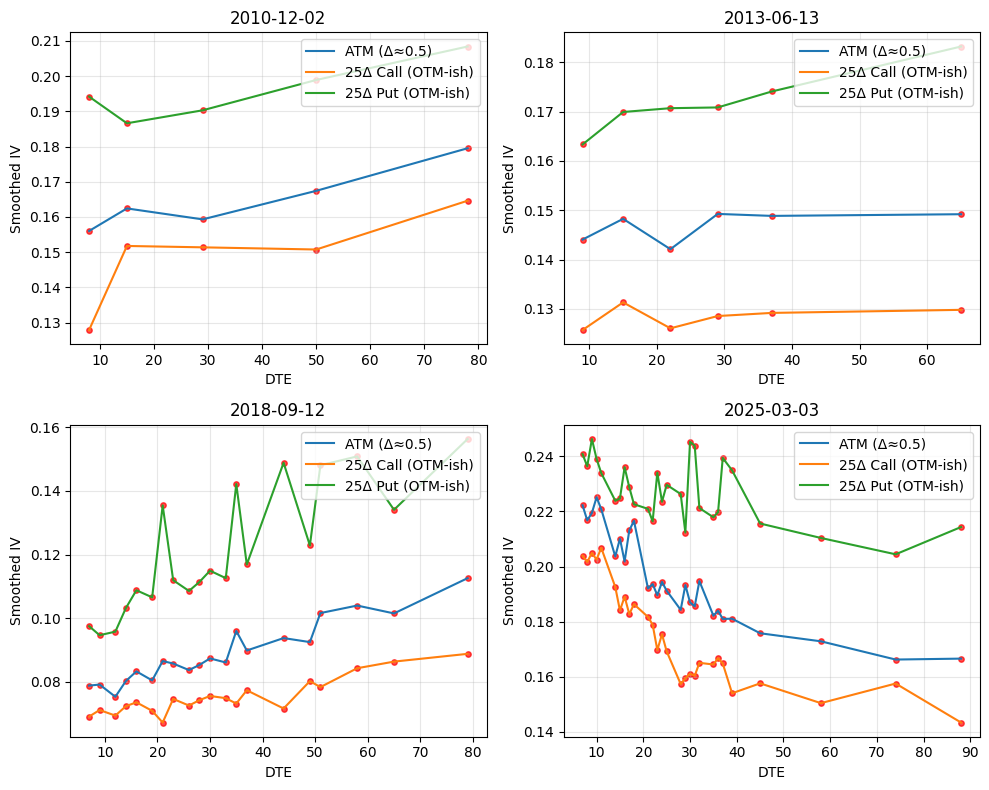

In [16]:
# --- targets: which call-delta curves we want along the term-structure -----
delta_targets = [
    (0.50, "ATM (Δ≈0.5)"),
    (0.25, "25Δ Call (OTM-ish)"),
    (0.75, "25Δ Put (OTM-ish)"),
]

# --- 2x2 facet grid ---------------------------------------------------------
nrows, ncols = 2, 2
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(5 * ncols, 4 * nrows),
)
axes = axes.ravel()

for ax, day in zip(axes, picked_dates):
    sub = df.filter(pl.col("trade_date") == day)
    if sub.height == 0:
        ax.set_axis_off()
        continue

    for target_delta, label in delta_targets:
        # for each DTE, pick row whose call_delta is closest to target_delta
        ts = (
            sub
            .with_columns(
                (pl.col("call_delta") - target_delta)
                .abs()
                .alias("_dist")
            )
            .sort(["dte", "_dist"])
            .group_by("dte", maintain_order=True)
            .agg(
                pl.col("smoothed_iv").first().alias("smoothed_iv"),
            )
            .sort("dte")
        )

        if ts.height == 0:
            continue

        dte_vals = ts["dte"].to_numpy()
        iv_vals = ts["smoothed_iv"].to_numpy()

        # line for the term structure
        ax.plot(
            dte_vals,
            iv_vals,
            label=label,
            linewidth=1.5,
        )

        # original data points on top (markers)
        ax.scatter(
            dte_vals,
            iv_vals,
            s=15,
            alpha=0.7,
            color="red"
        )

    ax.set_xlabel("DTE")
    ax.set_ylabel("Smoothed IV")
    ax.set_title(day.strftime("%Y-%m-%d"))
    ax.grid(True, alpha=0.3)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc="upper right")

# hide unused axes if any
for k in range(len(picked_dates), len(axes)):
    axes[k].set_axis_off()

fig.tight_layout()
plt.show()

Here you can see all the weekly contracts that have been introduced over the years with their maturity less tha 5 calendar weeks (40 DTE). Beyond that only the monthly contracts are available this is why the term strcuture becomes very sparse for larger maturities.

In contrast to the smiles whihc are already smoothed, to get a clean synthetic IV series at a specific maturity some smoothing/interpolation is needed, especially for OTM puts a smoothing is key (take a look ta teh bottom right panel a syntehtic 30-DTE series would require fitting a smooth function).

# **Greeks Sanity Checks**

In [60]:
checks = df.select(
    # Deltas
    (pl.col("call_delta") <= 0).sum().alias("bad_call_delta_le_0"),
    (pl.col("call_delta") >= 1).sum().alias("bad_call_delta_ge_1"),
    (pl.col("put_delta") >= 0).sum().alias("bad_put_delta_ge_0"),
    (pl.col("put_delta") <= -1).sum().alias("bad_put_delta_le_minus1"),

    # Gamma & Vega
    (pl.col("call_gamma") < 0).sum().alias("neg_call_gamma"),
    (pl.col("put_gamma") < 0).sum().alias("neg_put_gamma"),
    (pl.col("call_vega") < 0).sum().alias("neg_call_vega"),
    (pl.col("put_vega") < 0).sum().alias("neg_put_vega"),

    # Rho sign
    (pl.col("call_rho") < 0).sum().alias("call_rho_negative"),
    (pl.col("put_rho") > 0).sum().alias("put_rho_positive"),

    # Theta sign (more relaxed: count how many are positive)
    (pl.col("call_theta") > 0).sum().alias("call_theta_positive"),
    (pl.col("put_theta") > 0).sum().alias("put_theta_positive"),
)

checks

bad_call_delta_le_0,bad_call_delta_ge_1,bad_put_delta_ge_0,bad_put_delta_le_minus1,neg_call_gamma,neg_put_gamma,neg_call_vega,neg_put_vega,call_rho_negative,put_rho_positive,call_theta_positive,put_theta_positive
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,127,0,0


In [65]:
viol = (df
    .filter(pl.col("put_rho") > 0)
    .select("trade_date", "dte", "put_delta", "put_rho")
)
viol

trade_date,dte,put_delta,put_rho
date,i64,f64,f64
2014-10-14,10,-0.010611,0.001512
2014-10-14,10,-0.011363,0.001127
2014-10-14,10,-0.012381,0.000597
2015-09-22,8,-0.010591,0.001195
2015-09-22,8,-0.011611,0.000764
…,…,…,…
2023-11-24,7,-0.014711,0.002554
2023-11-24,7,-0.016367,0.001086
2023-11-24,10,-0.010514,0.001932


Those violations occur only for **deep OTM puts** with **very short expiries**, and their magnitudes are tiny numerical noise.

In [16]:
viol = (df
    .filter(
        pl.col("put_rho") > 0,
        pl.col("put_delta").abs().is_between(0.05, 0.95)
    )
    .select("trade_date", "dte", "put_delta", "put_rho")
)
viol

trade_date,dte,put_delta,put_rho
date,i64,f64,f64


Inside the 5%-95% Delta band the violations completely dissapear so we cna safely ignore them.

# **Model-driven / arbitrage checks**

Before looking at theoretical arbitrage violations, it is important to
remember that **not all of the option chain is realistically tradable for us**.

- In practice we care mainly about:
  - **ATM options** (both calls and puts),
  - **OTM calls and puts**, and
  - some **deep OTM puts** (typically not below ~10-delta).
- Deep ITM options (|Δ| ≈ 1) are usually **not attractive for vol trading**:
  they behave almost like the underlying (delta ≈ ±1, other Greeks ≈ 0),
  so it is often cleaner to trade the underlying directly.

On the maturity side:

- Our horizon of interest is roughly **10–60 days to expiry**:
  - very short maturities (< 10 DTE) suffer from extreme time decay,
  - very long maturities (> 60 DTE) often have low VRP and liquidity is thinner.

Therefore:

- **Violations in far wings (very small or very large delta) and very short/long DTE
  are much less relevant** than violations inside our core tradable region
  (e.g. 10–90Δ, 10–60 DTE).

To make this concrete, we first visualise how **liquidity (volume / open interest)**
is distributed across moneyness and maturity.

In [24]:
df_long = orats_wide_to_long(df).filter(
    pl.col("trade_date").is_between(pl.date(2007, 1, 1), pl.date(2025, 12, 31))
).collect()

## Volume for Calls/Puts by $|\Delta|$ Moneyness

In [25]:
def plot_avg_volume_by_abs_delta(
    df_long: pl.DataFrame,
    delta_bins: np.ndarray,
    *,
    dte_min: int = 15,
    dte_max: int = 60,
    label_step: int = 2,
) -> None:
    vol_by_delta = (
        df_long
        .filter(pl.col("dte").is_between(dte_min, dte_max))
        .with_columns(
            delta_bucket = pl.col("delta").abs().cut(delta_bins),
        )
        .group_by(["delta_bucket", "option_type"])
        .agg(pl.col("volume").mean().alias("avg_volume"))
        .sort(["delta_bucket", "option_type"])
        .to_pandas()
    )

    pivot = vol_by_delta.pivot_table(
        index="delta_bucket",
        columns="option_type",   
        values="avg_volume",
    )

    edges = delta_bins
    labels = [f"{edges[i]:.2f}-{edges[i+1]:.2f}" for i in range(len(edges) - 1)]
    x = np.arange(len(pivot))

    plt.figure(figsize=(8, 4))
    if "C" in pivot.columns:
        plt.plot(x, pivot["C"], marker="o", label="Call volume")
    if "P" in pivot.columns:
        plt.plot(x, pivot["P"], marker="o", label="Put volume")

    plt.xticks(x[::label_step], labels[::label_step], rotation=25)
    plt.xlabel("|Delta| bucket")
    plt.ylabel("Average volume")
    plt.title("Average Options Volume by |Delta|")
    plt.legend()
    plt.tight_layout()
    plt.show()

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_1297/601861789.py:21: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = vol_by_delta.pivot_table(


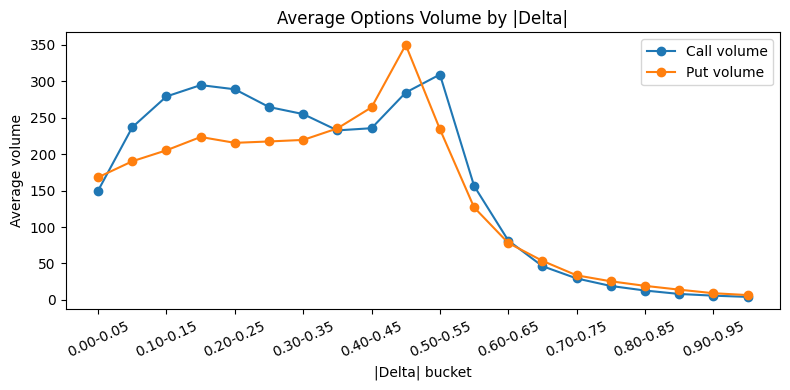

In [26]:
plot_avg_volume_by_abs_delta(
    df_long, 
    delta_bins=np.linspace(0.0, 1.0, 21), 
    dte_min=10, dte_max=60
)

As you can see we mostly care baout the 10-90 Delta region outside options have low liquidity whihc is translated by 
stale quotes and large spreads thus poentila arbitrage in those regions are usually not tradeable.

## Volume/Open Interest by DTE

In [27]:
def plot_liquidity_vs_dte(
    df_long: pl.DataFrame,
    dte_bins: list[int] | None = None,
    dte_labels: list[str] | None = None,
    *,
    delta_min: float = 0.1,
    delta_max: float = 0.9,
) -> None:

    liq_by_dte = (
        df_long
        .with_columns(
            dte_bucket = pl.col("dte").cut(dte_bins).alias("dte_bucket"),
        )
        .filter(pl.col("delta").abs().is_between(delta_min, delta_max))
        .group_by("dte_bucket")
        .agg(
            pl.col("volume").mean().alias("avg_volume"),
            pl.col("open_interest").mean().alias("avg_open_interest"),
        )
        .sort("dte_bucket")
    )

    liq_dte_pd = liq_by_dte.to_pandas()
    x = np.arange(len(liq_dte_pd))

    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax2 = ax1.twinx()
    ax1.bar(x - 0.15, liq_dte_pd["avg_volume"],
            width=0.3, label="Avg volume")
    ax2.bar(x + 0.15, liq_dte_pd["avg_open_interest"],
            width=0.3, alpha=0.7, label="Avg open interest")

    ax1.set_xticks(x)
    ax1.set_xticklabels(dte_labels, rotation=0)
    ax1.set_xlabel("DTE bucket")
    ax1.set_ylabel("Avg volume")
    ax2.set_ylabel("Avg open interest")
    ax1.set_title("Liquidity vs time to expiry")

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

    plt.tight_layout()
    plt.show()

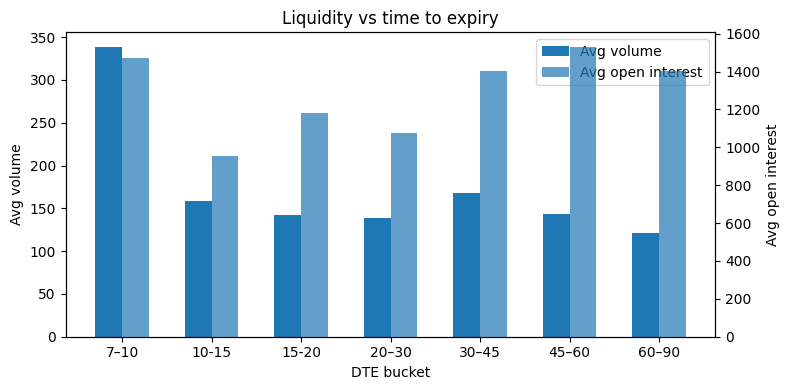

In [28]:
plot_liquidity_vs_dte(
    df_long,
    dte_bins = [10, 15, 20, 30, 45, 60, 90],
    dte_labels = ["7–10","10-15","15-20", "20–30", "30–45", "45–60", "60–90"],
    delta_min=0.1, delta_max=0.9
)

Most of the options we care are between 10 and 60 DTE below that options have too alrge gamma and are usually between for intraday trades and larger than 60 DTE low liquidity and open interest.

# **Put–Call Parity checks**

We start from **European put–call parity** with continuous dividend yield $q$ and
risk-free rate $r$:

$$
C - P = S e^{-qT} - K e^{-rT},
$$

where

- $C, P$ = call and put prices  
- $S$     = spot/underlying price  
- $K$     = strike  
- $T$     = time to expiry in years (our `yte`)  
- $q$     = dividend yield (`dividend_yield`)  
- $r$     = risk-free rate (`risk_free_rate`).

In [13]:
disc_r = (-df["risk_free_rate"] * df["yte"]).exp()
disc_q = (-df["dividend_yield"] * df["yte"]).exp()

Check parity usign mid prices and do bucket nalaysis across Delta/DTE

## Rho parity

Differentiate parity w.r.t. $r$:

$$
\frac{\partial C}{\partial r} - \frac{\partial P}{\partial r}
  = \frac{\partial}{\partial r} \left(S e^{-qT} - K e^{-rT}\right)
  = 0 - \left(-T K e^{-rT}\right)
  = T K e^{-rT}.
$$

If vendor rhos are defined **per 1% move in rates** (i.e. for $\Delta r = 0.01$),
then

$$
\rho_C = \frac{\partial C}{\partial (0.01 r)}, \quad
\rho_P = \frac{\partial P}{\partial (0.01 r)}
$$

so

$$
\rho_C - \rho_P
  = 0.01 \, T K e^{-rT}.
$$

Re-arranged in the “left minus right hand side ≈ 0” form we actually check:

$$
\rho_P - \rho_C - 0.01 \, T K e^{-rT} \approx 0.
$$

In [14]:
rhs = df["yte"] * df["strike"] * disc_r / 100
diff = df["call_rho"] - df["put_rho"] - rhs
diff.describe()

statistic,value
str,f64
"""count""",8.278626e6
"""null_count""",0.0
"""mean""",1.6881e-20
"""std""",1.0184e-16
"""min""",-3.5527e-15
"""25%""",0.0
"""50%""",0.0
"""75%""",0.0
"""max""",3.5527e-15


## Theta parity

Differentiate parity w.r.t. time to expiry $T$:

$$
\frac{\partial}{\partial T}(C - P)
= \frac{\partial}{\partial T}\left(S e^{-qT} - K e^{-rT}\right)
= -q S e^{-qT} + r K e^{-rT}.
$$

Define **annual** thetas (derivative per unit of $T$ in years):

$$
\Theta_C = \frac{\partial C}{\partial T}, \quad
\Theta_P = \frac{\partial P}{\partial T}.
$$

Then:

$$
\Theta_C - \Theta_P = -q S e^{-qT} + r K e^{-rT}.
$$

ORATS reports **1-day theta** (`call_theta`, `put_theta`) in
“per calendar day” units, we approximate:

$$
\theta_C \approx \frac{\Theta_C}{365}, \quad
\theta_P \approx \frac{\Theta_P}{365},
$$

so:

$$
\theta_C - \theta_P
\approx \frac{-q S e^{-qT} + r K e^{-rT}}{365}.
$$

Re-arranged in the check form (LHS − RHS $\approx 0$):

$$
\theta_P - \theta_C
- \frac{-q S e^{-qT} + r K e^{-rT}}{365}
\approx 0.
$$

In [54]:
term1 = df["dividend_yield"] * df["underlying_price"] * disc_q
term2 = df["risk_free_rate"] * df["strike"] * disc_r 

rhs = (term2 - term1) / 365
diff = df["call_theta"] - df["put_theta"] - rhs
diff.describe()

statistic,value
str,f64
"""count""",8.278626e6
"""null_count""",0.0
"""mean""",-4.2846e-20
"""std""",7.4062e-17
"""min""",-8.8818e-16
"""25%""",-2.4720e-17
"""50%""",0.0
"""75%""",2.4286e-17
"""max""",8.8818e-16


# **Arbitrage bounds for call & put prices**

For a European option on an underlying with spot $S$, strike $K$, maturity $T$,
risk–free rate $r$ and continuous dividend yield $q$, the **no-arbitrage price
bounds** in a simple Black–Scholes world are:

- **Discounted spot and strike**  
  $$
  \tilde S = S e^{-qT}, \qquad \tilde K = K e^{-rT}.
  $$

- **Call bounds**  
  $$
  C \;\ge\; \max\bigl(0,\;\tilde S - \tilde K\bigr), \qquad
  C \;\le\; \tilde S.
  $$

- **Put bounds**  
  $$
  P \;\ge\; \max\bigl(0,\;\tilde K - \tilde S\bigr), \qquad
  P \;\le\; \tilde K.
  $$


Here we are very restrcitive for uper bound violations as they would sugguets that our option data is garbage.

In [ ]:
TOL = 1e-6  # small numerical tolerance

# --- 1) Build discounted spot & strike -------------------------------------
df_bounds = df.lazy().with_columns(
    disc_r = (-pl.col("risk_free_rate") * pl.col("yte")).exp(),
    disc_q = (-pl.col("dividend_yield") * pl.col("yte")).exp(),
).with_columns(
    spot_disc  = pl.col("spot_price") * pl.col("disc_q"),   # S e^{-qT}
    strike_disc = pl.col("strike") * pl.col("disc_r"),      # K e^{-rT}
)

# --- 2) Theoretical lower/upper bounds -------------------------------------
df_bounds = df_bounds.with_columns(
    # Call bounds
    call_lb = pl.max_horizontal(
        pl.lit(0.0),
        pl.col("spot_disc") - pl.col("strike_disc"),
    ),
    call_ub = pl.col("spot_disc"),

    # Put bounds
    put_lb = pl.max_horizontal(
        pl.lit(0.0),
        pl.col("strike_disc") - pl.col("spot_disc"),
    ),
    put_ub = pl.col("strike_disc"),
)

# --- 3) Flag violations -----------------------------------------------------
df_bounds = df_bounds.with_columns(
    call_lb_violation = pl.col("call_mid_price") < (pl.col("call_lb") - TOL),
    call_ub_violation = pl.col("call_mid_price") > (pl.col("call_ub") + TOL),

    put_lb_violation  = pl.col("put_mid_price") < (pl.col("put_lb") - TOL),
    put_ub_violation  = pl.col("put_mid_price") > (pl.col("put_ub") + TOL),
)

# --- 4) Summary counts ------------------------------------------------------
summary = df_bounds.select(
    pl.len().alias("n_total"),

    pl.col("call_lb_violation").sum().alias("n_call_lb_viol"),
    pl.col("call_ub_violation").sum().alias("n_call_ub_viol"),

    pl.col("put_lb_violation").sum().alias("n_put_lb_viol"),
    pl.col("put_ub_violation").sum().alias("n_put_ub_viol"),
).collect()

summary

n_total,n_call_lb_viol,n_call_ub_viol,n_put_lb_viol,n_put_ub_viol
u32,u32,u32,u32,u32
8278626,719758,0,572381,0


## 2. Strike & maturity monotonicity checks

In a frictionless European setting (Black–Scholes with continuous dividend yield),
option prices satisfy a few monotonicity properties that are tightly linked to
vertical‐spread and calendar‐spread arbitrage.

In real data (NBBO quotes, American exercise, discrete dividends, microstructure
noise), these conditions can be **slightly violated**, so we treat them as
**soft sanity checks**:

- we **count** how many violations occur;
- we look at where they happen in the surface (DTE, moneyness);
- we make sure there is no obvious systematic data issue.

In [7]:
df_long = orats_wide_to_long(df).collect()

### 2.2 Vertical spread arbitrage (strike monotonicity)

Fix a trade date and an expiration (fixed maturity $T$). As a function of strike
$K$:

- **Calls** must be non-increasing in $K$
  $$
  C(K_1) \ge C(K_2) \quad \text{if } K_1 < K_2.
  $$
  Otherwise a vertical call spread would be mispriced.

- **Puts** must be non-decreasing in $K$
  $$
  P(K_1) \le P(K_2) \quad \text{if } K_1 < K_2.
  $$

We flag a violation whenever, within a given $(\text{trade\_date}, \text{expiry})$
bucket, the call (resp. put) mid price increases (resp. decreases) as strike
increases.

### Call Strike Monoticity Violations

In [10]:
# 1) Flag violations for calls
df_calls_qc = flag_strike_monotonicity_long(df_long, "C")

# 2) Summary by (DTE, delta) region
viol_by_region_calls = summarize_monotonicity_by_region(df_calls_qc)

# 3) Global percentage of violations among calls
n_viol_calls = df_calls_qc["strike_monot_violation"].sum()
pct_viol_calls_strike = n_viol_calls / df_calls_qc.height

print(f"Strike monotonicity violations for calls: {pct_viol_calls_strike:.4%}")
viol_by_region_calls.head(10)

Strike monotonicity violations for calls: 5.4552%


dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,viol_rate_glob
cat,cat,u32,u32,f64,f64,f64
"""(30, 60]""","""(0, 0.1]""",43388,307295,0.141193,0.096073,0.005241
"""(60, inf]""","""(0, 0.1]""",22567,170787,0.132135,0.04997,0.002726
"""(10, 30]""","""(0, 0.1]""",45600,354062,0.128791,0.100971,0.005508
"""(0, 10]""","""(0, 0.1]""",10758,83647,0.128612,0.023821,0.001299
"""(60, inf]""","""(0.25, 0.5]""",19052,221140,0.086154,0.042186,0.002301
"""(60, inf]""","""(0.5, 0.75]""",26550,313284,0.084747,0.058789,0.003207
"""(60, inf]""","""(0.75, 0.9]""",32582,393619,0.082775,0.072146,0.003936
"""(60, inf]""","""(0.1, 0.25]""",12220,150654,0.081113,0.027058,0.001476
"""(60, inf]""","""(0.9, 1]""",31762,506468,0.062713,0.07033,0.003837


The 5 highest violations appear deep OTM (delta <= 0.1) for calls while the next 5 highest appear for large maturity options (DTE >= 60). Thus those vioaltions are not probablematic.

In [76]:
del df_calls_qc; gc.collect()

2039

### Put Strike Monoticity Violations

In [23]:
n_viol_puts

514581

In [24]:
df_puts_qc.filter(
    pl.col("strike_monot_violation") == True,
    pl.col("delta").abs().is_between(0.1, 0.9),
    pl.col("dte").is_between(10, 60),
).height

151699

In [17]:
df_puts_qc.filter(pl.col("delta").is_between(0.02, 0.99))

ticker,trade_date,expiry_date,dte,yte,strike,underlying_price,spot_price,smoothed_iv,risk_free_rate,dividend_yield,volume,open_interest,rel_spread,bid_price,mid_price,ask_price,delta,gamma,theta,vega,rho,option_type,strike_monot_violation
str,date,date,i64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,cat,bool


In [11]:
# 1) Flag violations for puts
df_puts_qc = flag_strike_monotonicity_long(df_long, "P")

# 2) Summary by (DTE, delta) region
viol_by_region_puts = summarize_monotonicity_by_region(df_puts_qc)

# 3) Global percentage of violations among puts
n_viol_puts = df_puts_qc["strike_monot_violation"].sum()
pct_viol_puts_strike = n_viol_puts / df_puts_qc.height

print(f"Strike monotonicity violations for puts: {pct_viol_puts_strike:.4%}")
viol_by_region_puts.head(10)

Strike monotonicity violations for puts: 6.2158%


dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,viol_rate_glob
cat,cat,u32,u32,f64,f64,f64
"""(30, 60]""","""(0.9, 1]""",37185,307294,0.121008,0.072263,0.004492
"""(60, inf]""","""(0.9, 1]""",20407,170786,0.119489,0.039658,0.002465
"""(10, 30]""","""(0.9, 1]""",38994,354061,0.110134,0.075778,0.00471
"""(0, 10]""","""(0.9, 1]""",8803,83647,0.10524,0.017107,0.001063
"""(60, inf]""","""(0.1, 0.25]""",38191,393620,0.097025,0.074218,0.004613
"""(60, inf]""","""(0.25, 0.5]""",28855,313281,0.092106,0.056075,0.003485
"""(60, inf]""","""(0.5, 0.75]""",17299,221140,0.078226,0.033618,0.00209
"""(30, 60]""","""(0, 0.1]""",64739,849529,0.076206,0.125809,0.00782
"""(30, 60]""","""(0.1, 0.25]""",44444,603995,0.073583,0.086369,0.005369


All violatiosn appear in irrelevent tradeable put surface region except for the bucket DTE=(30, 60], DELTA=(0.1, 0.25] which is ineterts for skew based trades (e.g. Risk reversal structures) however the pct of vioaltions across lal puts is merely 0.5%.

In [9]:
del df_puts_qc; gc.collect()

20

Add a column for the avrage size of the vioaliton and teh avarge volume/OI observed for this bucket

Show now teh cpt of vioaltions isndie the 0.1, 0.9 and 10:60 DTE region.



### 2.3 Calendar arbitrage (maturity monotonicity)

Fix a trade date and a strike \(K\). As a function of maturity \(T\):

- **European calls** should be non-decreasing in \(T\):
  \[
  C(T_1) \le C(T_2) \quad \text{if } T_1 < T_2.
  \]

- **European puts** should also be non-decreasing in \(T\) under standard
  assumptions.

If a longer-dated option is strictly cheaper than a shorter-dated option with the
same strike and underlying, you can construct a calendar spread with negative
cost and non-negative payoff → calendar arbitrage.

We flag a violation whenever, for fixed \((\text{trade\_date}, \text{strike})\),
the mid price **decreases** as DTE increases.

- Plot average tradign volume / OI as a funciton of moneyness (across all epxiries) and as a fucntion of expiries (across moneyness)
- Plot the liquidity/OI over the years

Show that there is more open interest for OTM options than for ITM options. (because ITM contracts are msot of the time closed)

Show that deep ITM/OTM optiosn have low volume but hsow the volume is lowest for deep ITM than for deep OTM.

Show that relative spread is lwoest for deep ITM (option contract cost in the dozens or hundres so bid and ask very close even if low OI and low trading volume), and show it is the highest for deep OTM as options worth a few cents (like 0.45 bid and 0.9 ask)

Namelt the rel spread is usually strictly decerasign with moneyness (highest OTM and lowest ITM) but hwoever near ATM the closets to ATM contratc has usually higher OI and lower rel spread.
